In [ ]:
import numpy as np
from typing import Tuple
from scipy import special
from sklearn import metrics

import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, MaxPooling2D,Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical

import keras
from keras.models import Sequential
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras.datasets import cifar10
from keras import regularizers
from keras.callbacks import LearningRateScheduler
import numpy as np

# Set verbosity.
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
from sklearn.exceptions import ConvergenceWarning

import warnings
warnings.simplefilter(action="ignore", category=ConvergenceWarning)
warnings.simplefilter(action="ignore", category=FutureWarning)

In [ ]:
!pip install tensorflow_privacy

In [ ]:
from tensorflow_privacy.privacy.privacy_tests.membership_inference_attack import membership_inference_attack as mia
from tensorflow_privacy.privacy.privacy_tests.membership_inference_attack.data_structures import AttackInputData
from tensorflow_privacy.privacy.privacy_tests.membership_inference_attack.data_structures import AttackResultsCollection
from tensorflow_privacy.privacy.privacy_tests.membership_inference_attack.data_structures import AttackType
from tensorflow_privacy.privacy.privacy_tests.membership_inference_attack.data_structures import PrivacyMetric
from tensorflow_privacy.privacy.privacy_tests.membership_inference_attack.data_structures import PrivacyReportMetadata
from tensorflow_privacy.privacy.privacy_tests.membership_inference_attack.data_structures import SlicingSpec
from tensorflow_privacy.privacy.privacy_tests.membership_inference_attack import privacy_report

In [ ]:
import tensorflow_privacy

In [ ]:
dataset = 'cifar10'
num_classes = 10
activation = 'relu'
num_conv = 3

batch_size=64
epochs_per_report = 2
total_epochs = 50

lr = 0.00075

In [ ]:
def load_cifar10():
  """Loads MNIST-Dataset and preprocesses to combine training and test data."""
  
  # load the existing CIFAR10 dataset that comes in form of traing + test data and labels
  train, test = tf.keras.datasets.cifar10.load_data()
  train_data, train_labels = train
  test_data, test_labels = test

  # scale the images from color values 0-255 to numbers from 0-1 to help the training process
  train_data = np.array(train_data, dtype=np.float32) / 255
  test_data = np.array(test_data, dtype=np.float32) / 255

  # cifar10 labels come one-hot encoded, there
  train_labels = train_labels.flatten()
  test_labels = test_labels.flatten()

  return train_data, train_labels, test_data, test_labels

In [ ]:
train_data, train_labels, test_data, test_labels = load_cifar10()

170508288/170498071 [==============================] - 3s 0us/step


In [ ]:
y_train_indices = train_labels[:, np.newaxis]
y_test_indices = test_labels[:, np.newaxis]

In [ ]:
train_labels = tf.keras.utils.to_categorical(y_train_indices, num_classes)
test_labels = tf.keras.utils.to_categorical(y_test_indices, num_classes)

In [ ]:
input_shape = train_data.shape[1:]

In [ ]:
def train_cnn(input_shape: Tuple[int],
              num_classes: int,
              num_conv: int,
              activation: str = 'relu') -> tf.keras.models.Sequential:
  
  model = tf.keras.models.Sequential()
  model.add(tf.keras.layers.Input(shape=input_shape))

  # Conv layers
  for _ in range(num_conv):
    model.add(tf.keras.layers.Conv2D(32, (3, 3), activation=activation))
    model.add(tf.keras.layers.MaxPooling2D())

  model.add(tf.keras.layers.Flatten())
  model.add(tf.keras.layers.Dense(64, activation=activation))
  model.add(tf.keras.layers.Dense(num_classes))

  model.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
    metrics=['accuracy'])

  return model

In [ ]:
def my_model():
  """ Define a Keras model without much of regularization
  Such a model is prone to overfitting"""
  shape = (32, 32, 3)
  weight_decay = 1e-4
  model = Sequential()
  model.add(Conv2D(32, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay), input_shape=train_data.shape[1:]))
  model.add(Activation('elu'))
  model.add(BatchNormalization())
  model.add(Conv2D(32, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
  model.add(Activation('elu'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Dropout(0.2))
 
  model.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
  model.add(Activation('elu'))
  model.add(BatchNormalization())
  model.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
  model.add(Activation('elu'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Dropout(0.3))
 
  model.add(Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
  model.add(Activation('elu'))
  model.add(BatchNormalization())
  model.add(Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
  model.add(Activation('elu'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Dropout(0.4))
 
  model.add(Flatten())
  model.add(Dense(num_classes, activation='softmax'))
  model.add(tf.keras.layers.Dense(num_classes))
  
  model.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
    metrics=['accuracy'])

  return model

In [ ]:
init_model = train_cnn(input_shape, num_classes, num_conv=2, activation=activation)

In [ ]:
model_new = my_model()

In [ ]:
class PrivacyMetrics(tf.keras.callbacks.Callback):
  def __init__(self, epochs_per_report, model_name):
    self.epochs_per_report = epochs_per_report
    self.model_name = model_name
    self.attack_results = []

  def on_epoch_end(self, epoch, logs=None):
    epoch = epoch+1

    if epoch % self.epochs_per_report != 0:
      return

    print(f'\nRunning privacy report for epoch: {epoch}\n')

    logits_train = self.model.predict(train_data, batch_size=batch_size)
    logits_test = self.model.predict(test_data, batch_size=batch_size)

    prob_train = special.softmax(logits_train, axis=1)
    prob_test = special.softmax(logits_test, axis=1)

    privacy_report_metadata = PrivacyReportMetadata(
        accuracy_train=logs['val_accuracy'], 
        accuracy_test=logs['val_accuracy'],
        epoch_num=epoch,
        model_variant_label=self.model_name)

    attack_results = mia.run_attacks(
        AttackInputData(
            labels_train=y_train_indices[:, 0],
            labels_test=y_test_indices[:, 0],
            probs_train=prob_train,
            probs_test=prob_test),
        SlicingSpec(entire_dataset=True, by_class=True),
        attack_types=(AttackType.THRESHOLD_ATTACK,
                      AttackType.LOGISTIC_REGRESSION),
        privacy_report_metadata=privacy_report_metadata)

    self.attack_results.append(attack_results)

In [ ]:
all_reports = []

In [ ]:
train_labels.shape

(50000, 10)

In [ ]:
test_labels.shape

(10000, 10)

In [ ]:
callback = PrivacyMetrics(epochs_per_report, "Initial Model")
history = init_model.fit(
      train_data,
      train_labels,
      batch_size=batch_size,
      epochs=total_epochs,
      validation_data=(test_data, test_labels),
      callbacks=[callback],
      shuffle=True)

all_reports.extend(callback.attack_results)

Epoch 1/50
782/782 [==============================] - 15s 9ms/step - loss: 1.6147 - accuracy: 0.4155 - val_loss: 1.4222 - val_accuracy: 0.4891
Epoch 2/50
780/782 [============================>.] - ETA: 0s - loss: 1.2928 - accuracy: 0.5409
Running privacy report for epoch: 2

782/782 [==============================] - 17s 22ms/step - loss: 1.2927 - accuracy: 0.5410 - val_loss: 1.2242 - val_accuracy: 0.5718
Epoch 3/50
782/782 [==============================] - 6s 8ms/step - loss: 1.1686 - accuracy: 0.5903 - val_loss: 1.1442 - val_accuracy: 0.6076
Epoch 4/50
780/782 [============================>.] - ETA: 0s - loss: 1.0841 - accuracy: 0.6225
Running privacy report for epoch: 4

782/782 [==============================] - 18s 23ms/step - loss: 1.0840 - accuracy: 0.6225 - val_loss: 1.0563 - val_accuracy: 0.6417
Epoch 5/50
782/782 [==============================] - 6s 8ms/step - loss: 1.0152 - accuracy: 0.6477 - val_loss: 1.0222 - val_accuracy: 0.6506
Epoch 6/50
778/782 [=====================

In [ ]:
callback = PrivacyMetrics(epochs_per_report, "Improved Model")
history = model_new.fit(train_data,
      train_labels,
      batch_size=batch_size,
      epochs=total_epochs,
      validation_data=(test_data, test_labels),
      callbacks=[callback],
      shuffle=True)

all_reports.extend(callback.attack_results)

Epoch 1/50
782/782 [==============================] - 29s 34ms/step - loss: 2.1149 - accuracy: 0.2579 - val_loss: 2.0127 - val_accuracy: 0.3083
Epoch 2/50
781/782 [============================>.] - ETA: 0s - loss: 1.8748 - accuracy: 0.3637
Running privacy report for epoch: 2

782/782 [==============================] - 45s 58ms/step - loss: 1.8748 - accuracy: 0.3637 - val_loss: 1.7668 - val_accuracy: 0.3794
Epoch 3/50
782/782 [==============================] - 26s 33ms/step - loss: 1.7090 - accuracy: 0.3945 - val_loss: 1.7183 - val_accuracy: 0.3749
Epoch 4/50
781/782 [============================>.] - ETA: 0s - loss: 1.6169 - accuracy: 0.4179
Running privacy report for epoch: 4

782/782 [==============================] - 49s 63ms/step - loss: 1.6169 - accuracy: 0.4179 - val_loss: 1.6745 - val_accuracy: 0.4243
Epoch 5/50
782/782 [==============================] - 26s 33ms/step - loss: 1.5447 - accuracy: 0.4565 - val_loss: 1.5022 - val_accuracy: 0.4844
Epoch 6/50
781/782 [================

In [ ]:
results = AttackResultsCollection(all_reports)

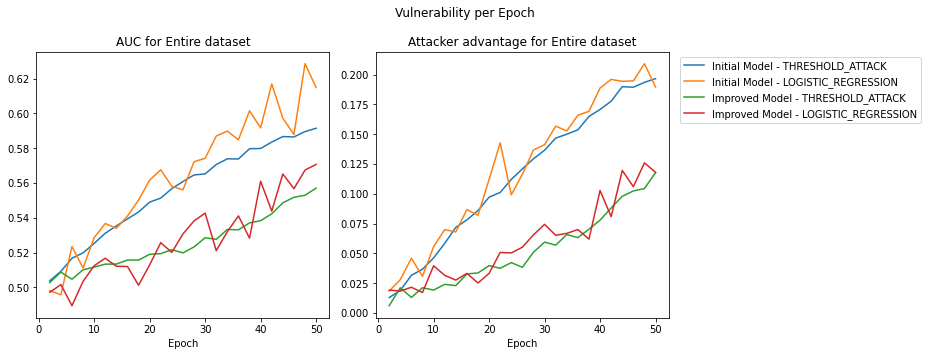

In [ ]:
privacy_metrics = (PrivacyMetric.AUC, PrivacyMetric.ATTACKER_ADVANTAGE)
epoch_plot = privacy_report.plot_by_epochs(
    results, privacy_metrics=privacy_metrics)

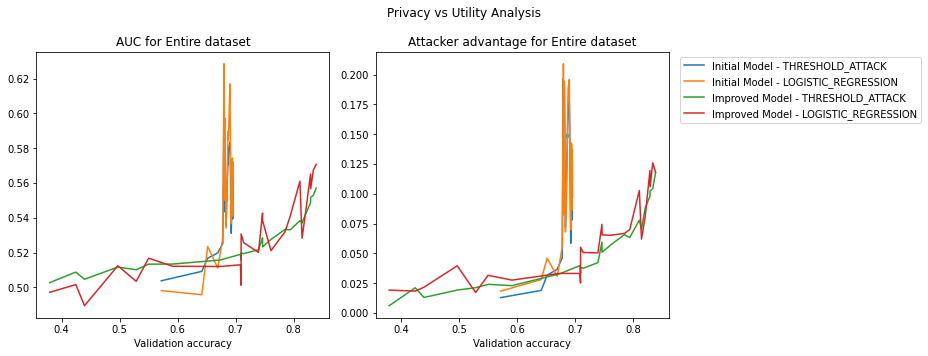

In [ ]:
privacy_metrics = (PrivacyMetric.AUC, PrivacyMetric.ATTACKER_ADVANTAGE)
utility_privacy_plot = privacy_report.plot_privacy_vs_accuracy(
    results, privacy_metrics=privacy_metrics)

for axis in utility_privacy_plot.axes:
  axis.set_xlabel('Validation accuracy')